In [1]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import shap
import joblib

sns.set(style="whitegrid")


C:\Users\bharg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np

dt = pd.read_csv(r'C:\Users\bharg\OneDrive\Documents\VSCodes\BEL_Full_Stock_Data_2002_2025.csv')

# Filter equity shares only
dt = dt[dt['series'] == 'EQ'].copy()

# Convert date column
dt['Date'] = pd.to_datetime(dt['Date'], format='%Y-%m-%d')

# Replace '-' with np.nan before conversion
dt.replace('-', np.nan, inplace=True)

# Columns to clean
num_cols = ['OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'ltp', 'close', 'vwap', '52W H', '52W L', 'VOLUME', 'VALUE']

for col in num_cols:
    # Remove commas, convert to float (errors='coerce' turns bad data to NaN)
    dt[col] = dt[col].astype(str).str.replace(',', '').astype(float)

# Drop rows with NaNs in critical columns
dt.dropna(subset=['Date', 'OPEN', 'HIGH', 'LOW', 'close', 'VOLUME'], inplace=True)

# Sort by Date ascending
dt = dt.sort_values('Date').reset_index(drop=True)

print(f"Data Shape: {dt.shape}")
print(dt.head())


Data Shape: (5887, 14)
        Date series   OPEN   HIGH    LOW  PREV. CLOSE    ltp  close   vwap  \
0 2002-01-01     EQ  83.55  86.45  82.30        82.80  83.65  83.15  84.36   
1 2002-01-02     EQ  84.00  85.00  83.00        83.15  85.00  84.30  84.06   
2 2002-01-03     EQ  85.50  88.00  85.00        84.30  85.15  85.85  85.68   
3 2002-01-04     EQ  87.70  88.00  85.00        85.85  85.00  85.35  85.83   
4 2002-01-07     EQ  87.00  87.80  85.05        85.35  86.95  86.00  86.37   

   52W H  52W L   VOLUME       VALUE No of trades  
0   99.0   44.0  29368.0  2477442.65          NaN  
1   99.0   44.0  15373.0  1292245.05          NaN  
2   99.0   44.0  32570.0  2790594.95          NaN  
3   99.0   44.0  27795.0  2385740.65          NaN  
4   99.0   44.0  16221.0  1401051.45          NaN  


Basic Stats:
              OPEN         HIGH          LOW        close        VOLUME
count  5887.000000  5887.000000  5887.000000  5887.000000  5.887000e+03
mean    863.193241   878.834853   847.161931   861.633216  5.165048e+06
std     775.821538   790.076821   761.389607   773.917254  1.147656e+07
min      57.800000    61.200000    56.000000    58.450000  4.770000e+02
25%     178.975000   181.725000   175.425000   178.700000  5.206550e+04
50%     700.900000   717.950000   685.050000   700.750000  1.922760e+05
75%    1330.000000  1360.000000  1306.850000  1333.100000  6.770046e+06
max    4150.000000  4160.000000  4070.050000  4126.600000  2.680527e+08


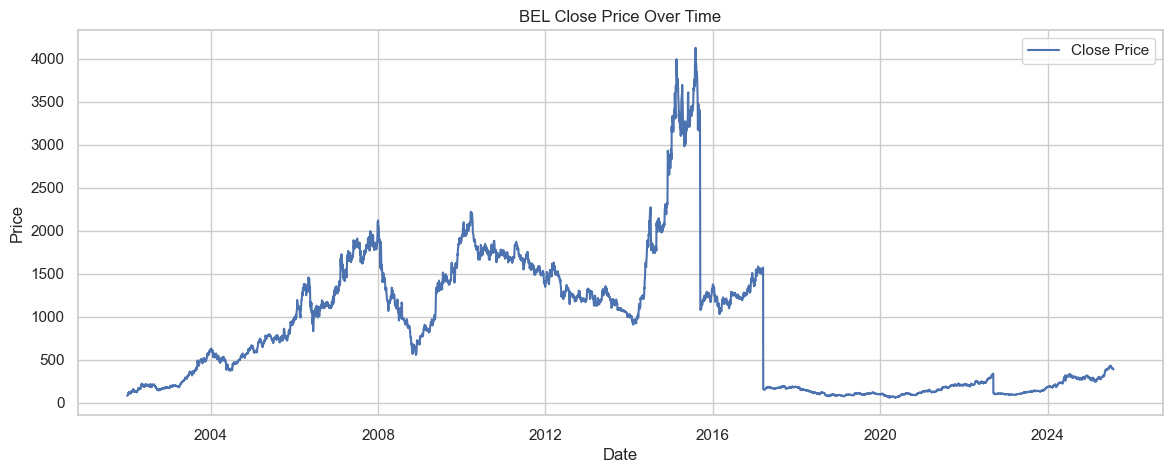

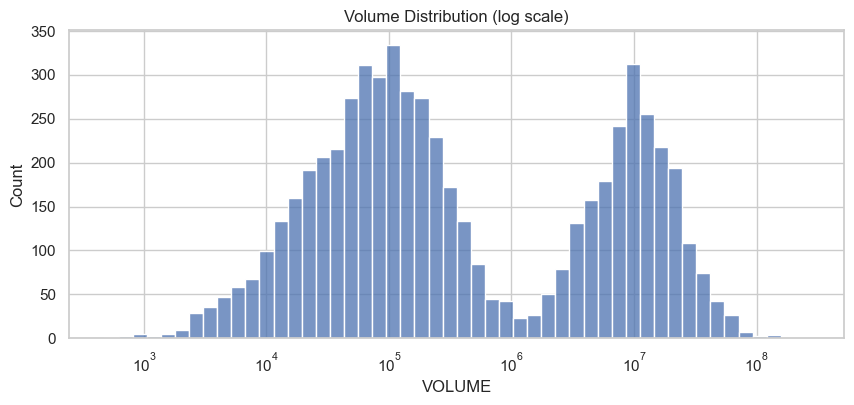

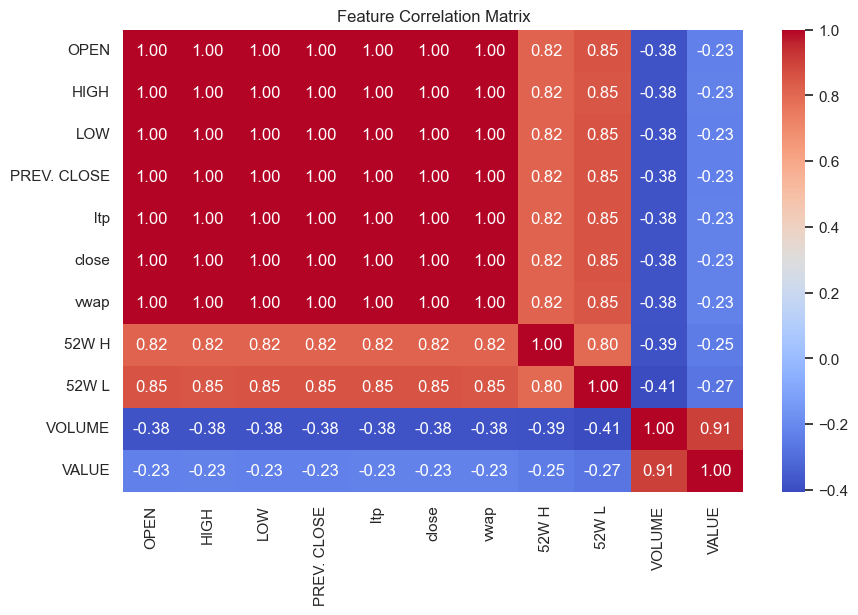

In [3]:
# 3. Exploratory Data Analysis (EDA)

print("Basic Stats:")
print(dt[['OPEN', 'HIGH', 'LOW', 'close', 'VOLUME']].describe())

# Plot closing price trend
plt.figure(figsize=(14,5))
plt.plot(dt['Date'], dt['close'], label='Close Price')
plt.title('BEL Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Volume distribution
plt.figure(figsize=(10,4))
sns.histplot(dt['VOLUME'], bins=50, log_scale=True)
plt.title('Volume Distribution (log scale)')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(dt[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [4]:
# 4. Feature Engineering

df = dt.copy()

# Price change between Open and Close
df['Price_Change'] = df['close'] - df['OPEN']

# Daily return (pct change in close)
df['Return'] = df['close'].pct_change()

# Rolling statistics (window 5 and 10)
df['Rolling_Mean_5'] = df['close'].rolling(window=5).mean()
df['Rolling_Mean_10'] = df['close'].rolling(window=10).mean()
df['Rolling_Std_10'] = df['close'].rolling(window=10).std()

# Volatility as rolling std of returns
df['Volatility_10'] = df['Return'].rolling(window=10).std()

# Lag features for close price (1 to 5 days)
for lag in range(1, 6):
    df[f'Lag_{lag}'] = df['close'].shift(lag)

# Drop rows with NaNs created by rolling/lag
df = df.dropna().reset_index(drop=True)

print(f"After feature engineering, shape: {df.shape}")
print(df.head())


After feature engineering, shape: (3531, 25)
        Date series     OPEN    HIGH      LOW  PREV. CLOSE      ltp    close  \
0 2011-06-01     EQ  1682.20  1715.0  1671.60      1661.45  1715.00  1710.40   
1 2011-06-02     EQ  1697.95  1713.0  1668.10      1710.40  1677.00  1676.00   
2 2011-06-03     EQ  1697.65  1697.7  1645.35      1676.00  1652.05  1653.55   
3 2011-06-06     EQ  1655.00  1682.0  1655.00      1653.55  1670.10  1675.20   
4 2011-06-07     EQ  1675.00  1686.7  1661.95      1675.20  1678.00  1678.00   

      vwap   52W H  ...    Return  Rolling_Mean_5  Rolling_Mean_10  \
0  1686.85  1928.4  ...  0.029462         1680.18         1693.270   
1  1689.77  1928.4  ... -0.020112         1680.15         1690.645   
2  1666.02  1928.4  ... -0.013395         1673.39         1683.945   
3  1668.97  1928.4  ...  0.013093         1675.32         1682.760   
4  1678.47  1928.4  ...  0.001671         1678.63         1680.300   

  Rolling_Std_10  Volatility_10    Lag_1    Lag_2    

In [5]:
# 5. Define Target & Features

# Target: Next day closing price
df['Target'] = df['close'].shift(-1)

# Drop last row with NaN target
df = df.dropna().reset_index(drop=True)

# Features list
features = ['OPEN', 'HIGH', 'LOW', 'VOLUME', 'Price_Change', 'Return',
            'Rolling_Mean_5', 'Rolling_Mean_10', 'Rolling_Std_10', 'Volatility_10'] + [f'Lag_{i}' for i in range(1, 6)]

X = df[features]
y = df['Target']

print(f"Features shape: {X.shape}, Target shape: {y.shape}")


Features shape: (3530, 15), Target shape: (3530,)


In [6]:
# 6. Train-Test Split using TimeSeriesSplit (better for time series)

tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}: Train size = {len(train_idx)}, Test size = {len(test_idx)}")


Fold 1: Train size = 590, Test size = 588
Fold 2: Train size = 1178, Test size = 588
Fold 3: Train size = 1766, Test size = 588
Fold 4: Train size = 2354, Test size = 588
Fold 5: Train size = 2942, Test size = 588


In [7]:
# 7. Model Training - Use XGBoost Regressor with basic hyperparams

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train on first 80% of data (chronologically)
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Performance:\nMAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR2: {r2:.4f}")


XGBoost Performance:
MAE: 19.5834
MSE: 2500.9614
RMSE: 50.0096
R2: 0.7275


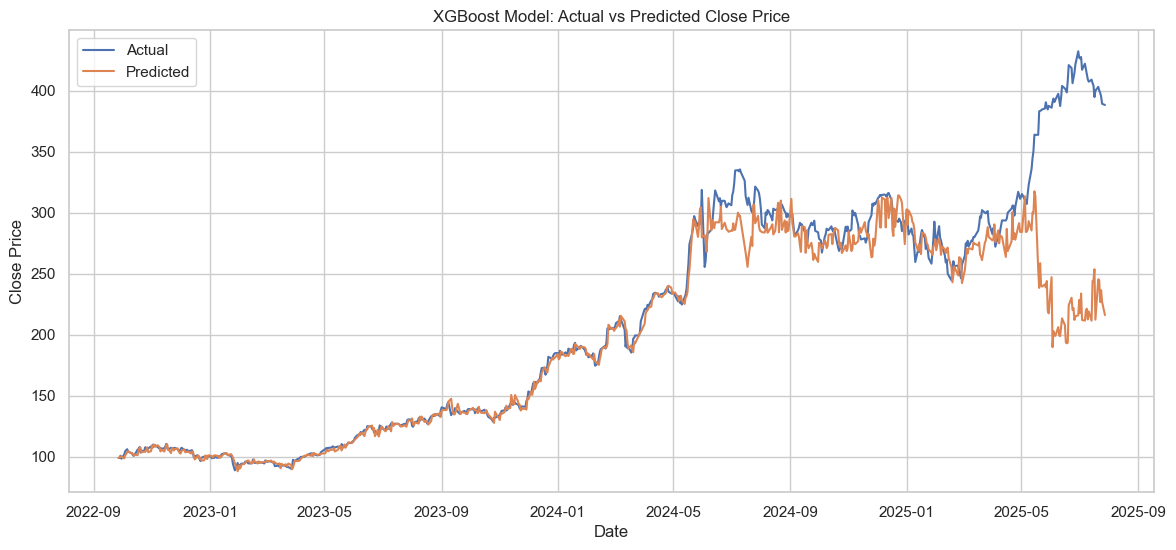

In [8]:
# 8. Plot Actual vs Predicted Closing Prices

plt.figure(figsize=(14,6))
plt.plot(df['Date'].iloc[split_idx:], y_test, label='Actual')
plt.plot(df['Date'].iloc[split_idx:], y_pred, label='Predicted')
plt.title('XGBoost Model: Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


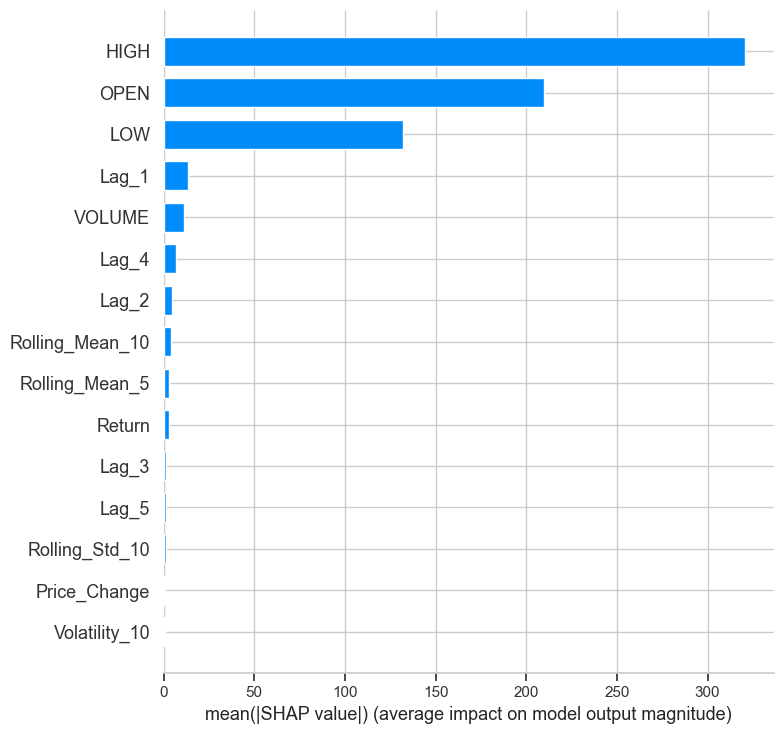

In [10]:
# 9. SHAP Explainability

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


In [11]:
# 10. Save Model for Production

joblib.dump(xgb_model, 'bel_xgb_model.pkl')
print("Model saved as 'bel_xgb_model.pkl'")


Model saved as 'bel_xgb_model.pkl'
